In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Import needed packages
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
from tensorflow import keras
from tensorflow.keras import models, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import DirectoryIterator
from tensorflow.keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from keras import optimizers
from datetime import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
from sklearn.metrics import confusion_matrix

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
main_path = '/content/gdrive/My Drive/Thesis/Data/COVID-classification/'
train_path_org = main_path+'train/'
test_path_org = main_path+'test/'
val_path_org = main_path+'val/'

In [ ]:
train_path_mask = main_path+'train_masks/'
test_path_mask = main_path+'test_masks/'
val_path_mask = main_path+'val_masks/'

In [ ]:
#Loading the DenseNet-121 model to test original model

dense = DenseNet121(include_top=False, weights='imagenet' ,input_shape=(512, 512, 3))

for layer in dense.layers:
  layer.trainable = False

x = Flatten()(dense.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
pred = Dense(1, activation='sigmoid')(x)

model = keras.Model(dense.input, pred)


# summarize the model
#model.summary()

29089792/29084464 [==============================] - 3s 0us/step


In [ ]:
adam = optimizers.Adam()
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

In [ ]:
train_set = DirectoryIterator(train_path_org,
                            datagen,
                            target_size = (512, 512),
                            batch_size = 32,
                            class_mode = 'binary',
                            shuffle = True)

Found 7070 images belonging to 2 classes.


In [ ]:
train_set_mask = DirectoryIterator(train_path_mask,
                            datagen,
                            target_size = (512, 512),
                            batch_size = 32,
                            class_mode = 'binary',
                            shuffle = True)

Found 7070 images belonging to 2 classes.


In [ ]:
val_set = DirectoryIterator(val_path_org,
                            datagen,
                            target_size = (512, 512),
                            batch_size = 32,
                            class_mode = 'binary',
                            shuffle = True)

Found 786 images belonging to 2 classes.


In [ ]:
val_set_mask = DirectoryIterator(val_path_mask,
                            datagen,
                            target_size = (512, 512),
                            batch_size = 32,
                            class_mode = 'binary',
                            shuffle = True)

Found 786 images belonging to 2 classes.


In [ ]:
test_set = DirectoryIterator(test_path_org,
                            datagen,
                            target_size = (512, 512),
                            batch_size = 32,
                            class_mode = 'binary',
                            shuffle = False)

Found 1965 images belonging to 2 classes.


In [ ]:
test_set_mask = DirectoryIterator(test_path_mask,
                            datagen,
                            target_size = (512, 512),
                            batch_size = 32,
                            class_mode = 'binary',
                            shuffle = False)

Found 1965 images belonging to 2 classes.


In [ ]:
# train model on original data
with tf.device('/device:GPU:0'):
  early = EarlyStopping(monitor='val_loss', patience=5)
  check = ModelCheckpoint('/content/gdrive/My Drive/Thesis/models/DenseNet-1.h5', save_best_only=True, monitor='val_loss', mode='min')
  model_history=model.fit(
    train_set,
    validation_data=val_set,
    epochs=40,
    callbacks=[early,check],
    verbose=1)

Epoch 1/40
221/221 [==============================] - 5134s 23s/step - loss: 2.3577 - accuracy: 0.8639 - val_loss: 0.1151 - val_accuracy: 0.9631
Epoch 2/40
221/221 [==============================] - 239s 1s/step - loss: 0.1533 - accuracy: 0.9539 - val_loss: 0.1111 - val_accuracy: 0.9771
Epoch 3/40
221/221 [==============================] - 239s 1s/step - loss: 0.1222 - accuracy: 0.9576 - val_loss: 0.0791 - val_accuracy: 0.9720
Epoch 4/40
221/221 [==============================] - 239s 1s/step - loss: 0.0847 - accuracy: 0.9743 - val_loss: 0.1194 - val_accuracy: 0.9491
Epoch 5/40
221/221 [==============================] - 239s 1s/step - loss: 0.0847 - accuracy: 0.9721 - val_loss: 0.1002 - val_accuracy: 0.9669
Epoch 6/40
221/221 [==============================] - 237s 1s/step - loss: 0.0730 - accuracy: 0.9741 - val_loss: 0.0992 - val_accuracy: 0.9695
Epoch 7/40
221/221 [==============================] - 236s 1s/step - loss: 0.0623 - accuracy: 0.9751 - val_loss: 0.0862 - val_accuracy: 0.96

In [ ]:
y_pred = model.predict(test_set)

confusion_matrix(test_set.labels, y_pred.round())

array([[966,   5],
       [ 14, 980]])

In [ ]:
# original data
model.evaluate(test_set)

62/62 [==============================] - 58s 924ms/step - loss: 0.0431 - accuracy: 0.9903


[0.0431087464094162, 0.9903308153152466]

Now the same model will be trained on data that has been processed to have a mask over the image.

In [ ]:
#Loading the inceptionV3 model to test original model

dense_masks = DenseNet121(include_top=False, weights='imagenet' ,input_shape=(512, 512, 3))

for layer in dense_masks.layers:
  layer.trainable = False

x = Flatten()(dense_masks.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
pred = Dense(1, activation='sigmoid')(x)

model_masks = keras.Model(dense_masks.input, pred)


# summarize the model
#model.summary()

In [ ]:
model_masks.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  early = EarlyStopping(monitor='val_loss', patience=5)
  check = ModelCheckpoint('/content/gdrive/My Drive/Thesis/models/DenseNet_masks-1.h5', save_best_only=True, monitor='val_loss', mode='min')
  model_history_masks=model_masks.fit(
    train_set_mask,
    validation_data=val_set_mask,
    epochs=40,
    callbacks=[early,check],
    verbose=1)

Epoch 1/40
221/221 [==============================] - 4911s 22s/step - loss: 6.6929 - accuracy: 0.6139 - val_loss: 0.5692 - val_accuracy: 0.7824
Epoch 2/40
221/221 [==============================] - 234s 1s/step - loss: 0.5764 - accuracy: 0.7136 - val_loss: 0.4795 - val_accuracy: 0.8092
Epoch 3/40
221/221 [==============================] - 234s 1s/step - loss: 0.5249 - accuracy: 0.7495 - val_loss: 0.4188 - val_accuracy: 0.8130
Epoch 4/40
221/221 [==============================] - 236s 1s/step - loss: 0.4611 - accuracy: 0.7938 - val_loss: 0.3671 - val_accuracy: 0.8626
Epoch 5/40
221/221 [==============================] - 236s 1s/step - loss: 0.3967 - accuracy: 0.8307 - val_loss: 0.3250 - val_accuracy: 0.8511
Epoch 6/40
221/221 [==============================] - 233s 1s/step - loss: 0.3364 - accuracy: 0.8612 - val_loss: 0.2610 - val_accuracy: 0.8880
Epoch 7/40
221/221 [==============================] - 232s 1s/step - loss: 0.2778 - accuracy: 0.8880 - val_loss: 0.2492 - val_accuracy: 0.88

In [ ]:
model_masks = load_model('/content/gdrive/My Drive/Thesis/models/DenseNet_masks-1.h5', compile=False)
model_masks.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
y_pred_masks = model_masks.predict(test_set_mask)

confusion_matrix(test_set_mask.labels, y_pred.round())

array([[871, 100],
       [109, 885]])

In [ ]:
# masked data
model_masks.evaluate(test_set_mask)

62/62 [==============================] - 85s 920ms/step - loss: 0.2729 - accuracy: 0.8856


[0.25044479966163635, 0.8936386704444885]

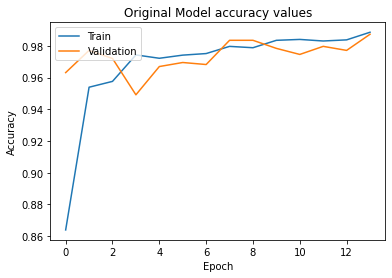

In [ ]:
# Plot train and validation accuracy of the model trained on original data
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Original Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

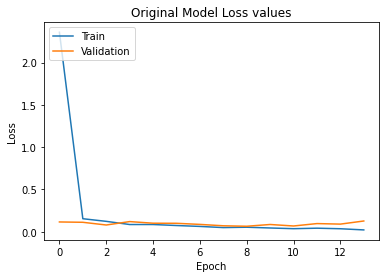

In [ ]:
# Plot train and validation accuracy of the model trained on original data
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Original Model Loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

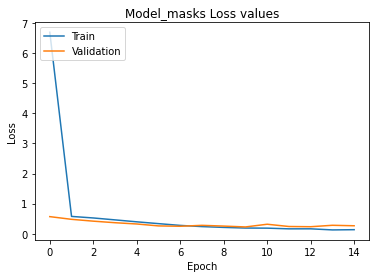

In [ ]:
# Plot train and validation accuracy of the model trained on masked data
plt.plot(model_history_masks.history['loss'])
plt.plot(model_history_masks.history['val_loss'])
plt.title('Model_masks Loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

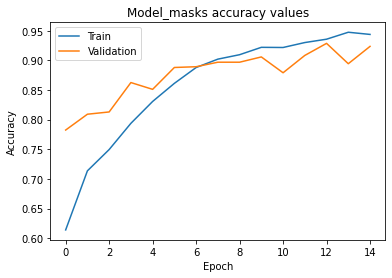

In [ ]:
# Plot train and validation accuracy of the model trained on masked data
plt.plot(model_history_masks.history['accuracy'])
plt.plot(model_history_masks.history['val_accuracy'])
plt.title('Model_masks accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()